# Learning from data 2018 - Project 2

## Instructions

| Date set     | Hand-in date |
|------------------|-----------------------------------|
|13th November 2018  | **12:00 3rd December 2018** |



Candidate number: 031831

Your report should consist of your Jupyter notebook showing what you did (including technical descriptions of the implemented algorithms), what was the result and what you can conclude from the experiments. Each report will be
assessed on the following criteria:

* Does it record what was done including the details of the implemented algorithms?
* Does it permit the results to be reproduced?
* How does the work relate to the theoretical foundations discussed in lectures?
* Is it well presented?

Use markdown to explain what you are doing (including equations, if any), what the results mean, how they relate to the theory, etc.

You can add new cells as you think fit and delete ones that are not needed (do not delete this preamble). 

### Submitting the notebooks

Only an electronic submissions is required.  Submit your notebook (the .ipynb file) to electronic copy via the  [electronic hand-in system](http://empslocal.ex.ac.uk/submit/) using the topic:
- <cmd>2018-12-03~ECM3420~Lorenzo Livi~cw2</cmd>
- <cmd>2018-12-03~ECMM445~Lorenzo Livi~cw2</cmd>

You should be able to upload the notebook directly from wherever it is on your machine.  If you're not sure where it is, type <code>pwd</code> (print working directory) in a cell to find out.  To keep the marking anonymous, please don't leave directory names that reveal your identity in cells.

<div class="alert alert-warning">
Although you will undoubtedly work collaboratively in the workshops themselves, these are *individual* exercises.  The reports you write should be about the results *you* obtained, and your attention is drawn to the College and University guidelines on collaboration and plagiarism. 

## Project specification

The project consists of two parts, each one worth 5% of the total 10% associated with this assessed workshop.

- **First part of the project**

Implement a standard echo state network (ESN) model. Do not include feedback from the output and do not include leaking neurons. Implement training of the read-out by solving a standard regularized least-square problem. Perform some preliminary simulations by considering a _k_ step ahead forecasting task (evaluate several values of *k* as forecasting horizon) on the "2sine" time series and describe the experimental results.
    
- **Second part of the project**

Implement a version of the ESN model that is trained online by means of the least-mean-square algorithm. Perform simulations to compare the performance on a k step ahead forecasting task with respect to the standard ESN implementation (first part of the project). In the experiments, take into account multiple _k_ values for the forecasting horizon (i.e., explore the effects of increasing *k* on the performance) and process the "2sine" and "lorenz" time series provided in the archive.

## Your project starts from here!

In [1]:
# make sure plots are displayed correctly on notebooks
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Part 1 of the project...

#### Import data

Length of data set = 2000


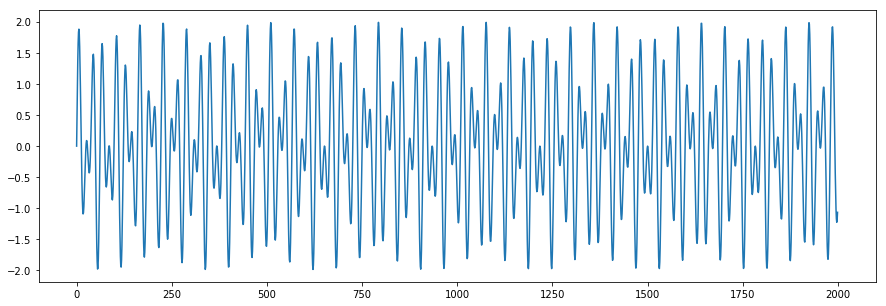

In [2]:
def getData():
    return genfromtxt("./2sin",delimiter=",")

figure(figsize=(15,5))
X = getData()
print("Length of data set =",len(X))
plot(X)
plt.show()

#### What is an Echo State Network?

An Echo State Network is an example of a reservoir computing. By having a large reservoir of untrained, randomly generated, neurons (relative to the input), and training only the weights related to the output, allows these sparse random connections to "echo" previous elements from the time series, allowing it to mimic the pattern of previously trained upon data, should the system recieve a similar input.

The standard formula for Echo State Networks, without feedback from outputs, follows as:

\begin{align*}
x_t = \phi(W^rx_t{_-{_1}} + W^{in}u_t + \epsilon)\text{,}
\end{align*}
\begin{align*}
y_t = W^{out}x_t
\end{align*}

Where $W^r$ and $W^{in}$ are randomly initialized.

#### Generate $W^{in}$

$W^i$, where $W^{in} \in \mathbb{R}^{N_r \times N_i{_n}}$, has each of it's elements randomized from a uniform distribution of $[-1,1]$. While not mentioned in the lecture notes, most papers talk about the sparsity of $W^{in}$, by having a large number of the element of $W^{in}$ equal zero. While in general sparse connections are slated to give better performances, M. Lukosevicius discusses in his 2012 paper *A Practical Guide to Applying Echo State Networks* how slight this increased performance is, giving sparsity the least importance among all hyper-parameters.

In [21]:
def GenerateWi(Nr, Nin, sparsity = 0):
    ### Args:
    ###   Nr is the number of neurons in the recurrent layer
    ###   Nin is the number of input neurons
    ###   sparsity is the percentage of elements turned to zero
    
    out = np.random.uniform(low = -1.0, high = 1.0, size = (Nr,Nin))
    
    ## ADDS ZERO ELEMENTS TO Win TO MAKE IT A SPARSE MATRIX
    if(sparsity != 0):
        sN = int(sparsity * Nr * Nin)
        sNr = np.random.randint(0, Nr,  sN)
        sNi = np.random.randint(0, Nin, sN)
        for i in range(sN):
            out[sNr[i],sNi[i]] = 0
        
    return out

##### Generate $W^r$
As the resulting values of $W^r$, where $W^r \in \mathbb{R}^{N_r \times N_r}$, have a direct effect on how the algorithm functions, they method of randomly generating $W^r$ is not one set method. One method, described in the lecture notes, $W^r$ is assigned by a uniform distribution over $[-1,1]$, scaled to match the spectral radius $a \approx 1$, where $W^r =  a\frac{W^r}{\rho(W^r)}$ and $\rho(W^r)$ is the spectral radius of $W^r$. Large values of $\rho(W^r)$ will cause the echo state property, that defining feature of an echo state network, to fail/be violated. Hence the value of $a$ is used to scale it to $\approx 1$ where this echo state property is most likely to hold.

In [20]:
def GenerateWrUniform(Nr, a):
    ### Args:
    ###   Nr is the number of neurons in the recurrent layer
    ###   a is a hyper-parameter to control the generation of W^r
    
    W = np.random.uniform(low = -1.0, high = 1.0, size = (Nr,Nr))
    Wrho = np.max(np.abs(np.linalg.eigvals(W)))
    return a * (W / Wrho)

Another method described in the lecture notes for creating the initial value of $W^r$ is to have a gaussian distribution $\mathcal{N}(0,g^2\textit{/}N_r)$, where $g \approx 1$ is another hyper parameter, similar to $a$.

In [19]:
def GenerateWrGaussian(Nr, g):
    ### Args:
    ###   Nr is the number of neurons in the recurrent layer
    ###   g is a hyper-parameter to control the generation of W^r
    
    W = np.random.normal(loc = 0.0, scale = g**2 / Nr, size = (Nr, Nr))
    return W

Methods suggested outside of the lecture notes include deterministic models such as Cycle Reservoir with Jumps (CRJ) as suggested by A. Rodan and P. Tino in their paper $\text{Simple Deterministically Constructed Cycle Reservoirs with Regular Jumps}$. In the CRJ model, rather than all of weights being individually random, the value of $W^r$ instead has the diagonal $W^r_{i+1,i} = r_c$, for $i = 1...N-1$ and $W^r_{1,N} = r_c$ to give a cyclical value for the weights so each of the neurons in the recurrent layer effects the next in order. Additionally there are jump entries in $W^r$ where, in the case of having the recurrent neurons in a cycle, starting from the first neuron, every $\lambda$ neurons are also linked (with a non-zero weight) by the value of $r_j$. These connectins are bi-directional. $\lambda$ is another hyper-parameter. How this is represented is shown below.

Additionally CRJs also have an alternate $W^i$ to compensate for these changes, where rather than being randomly determined, the values are once again deterministic and are the set absolute value of $v$. In the paper the sign of $v$ is changed based on the value of the related digit of $\pi$ for each value of $W^i$, where $0\leq$digit$\leq4$ has the sign of $v$ be -, and for all other cases, +. Rather than implement this method, I simply had it randomly decide. $r^c$, $\lambda$, $r^j$, and $v$ are all hyper-parameters to be determined.

![title](Image/CRJ.png)

In [18]:
def GenerateWrCRJ(Nr, rc, rj, l):
    ### Args:
    ###   Nr is the number of neurons in the recurrent layer
    ###   rc is the hyper-parameter for the weight value between the cycle
    ###   rj is the hyper-parameter for the weight value between jumps
    ###   l is the hyper-parameter for length of jumps
    
    W = np.zeros((Nr, Nr))
    for i in range(Nr-1):
        W[i+1,i] = rc
    W[0,Nr - 1] = rc
    for i in range(Nr // l):
        j = (i * l) % Nr
        k = ((i + 1) * l) % Nr
        W[j,k] = rj
        W[k,j] = rj
    return W
        
        
        
def GenerateWiCRJ(Nr, Nin, v, sparsity = 0):
    ### Args:
    ###   Nr is the number of neurons in the recurrent layer
    ###   Nin is the number of neurons in the input layer
    ###   v is the hyper-parameter for the absolute value of each element
    ###   sparsity is the percentage of elements turned to zero
    
    from random import random        
    
    Wi = np.full((Nr,Nin),v)
    
    for i in range(Nr):
        for j in range(Nin):
            if (random() < 0.5):
                Wi[i,j] *= -1
    
    ## ADDS ZERO ELEMENTS TO Win TO MAKE IT A SPARSE MATRIX
    if(sparsity != 0):
        sN = int(sparsity * Nr * Nin)
        sNr = np.random.randint(0, Nr,  sN)
        sNi = np.random.randint(0, Nin, sN)
        for i in range(sN):
            out[sNr[i],sNi[i]] = 0
        
    return Wi

#### Training
To train the network to a forecasting task, we parse the input and have the output be the value k-steps ahead, giving the task of $\{u_i,t_i\}^N_{i=1}$ where $t_i$ is k steps ahead of $u_i$. $u_i$ in the case of this task in $m$ ordered elements from the data. 

In [17]:
def splitDataAll(data, m, k):
    ### Args:
    ###   data is time series to be split into values of u_i
    ###   m is the length of each subset
    ###   k is number of steps before target
    
    
    data = np.array(data)
    n = np.shape(data)[0] - m - k
    try:
        U = np.zeros((n , m, np.shape(data)[1]))
        t = np.zeros((n , np.shape(data)[1]))
    except:
        U = np.zeros((n , m))
        t = np.zeros((n , 1))
    for i in range(len(data) - m - k):
        for j in range(m):
            U[i][j] = data[i+j]
        t[i] = data[i + m + k - 1]
    return U, t

In [16]:
def fit(Wr, Win, xt0, u):
    ### Args:
    ###   Wr is the matrix of random weights within the reservoir layer
    ###   Win is the matrix of random weight from the input layer
    ###   xt0 is the previous/current state being updated
    ###   u is the value of the input layer    
    
    pre = np.dot(Wr,xt0) + np.dot(Win,u)
    eps = (np.random.randn() * 0.05) ## RANDOM GUASSIAN ERROR
    return np.tanh(pre + eps) ## = Xt

##### Error Function
The tasks asks us to implement a regularized-least-squares error function. This is defined as follows:

\begin{align*}
E(y,y^{target}) = \frac{1}{n}\sum_{i=1}^{n}{(y^{target}_{i}-y_{i})^2}
\end{align*}

In [15]:
def error(y, yt):
    ### Args:
    ###   y is the output being tested
    ###   yt is the target output being tested aginst
    
    n = shape(y)[0]
    eps = 0
    for i in range(n):
        eps += (yt[i] - y[i])**2
    return eps/n

###### Ridge Regression
As $y_t = W^{out}x_{t}$, as seen in the lecture notes, we get $W^{out} = ((X^TX + \lambda^2I)^{-1} X^Tt)^T$, where $X$ is the collected N states of $x_i$, $t$ is all the related targets, and $\lambda \geq 0$ is the regularisation parameter. This can, however, just be changed to the more straightforward $W^{out} = y_t X^{+}$ where $X^{+}$ is the psuedoinverse of $X$

In [14]:
def ridgeReg(X, t):
    ### Args:
    ###   X is the collected N states of xi
    ###   t is all of the target related to xi
    
    out = np.dot(t,np.linalg.pinv(X))
    return out

#### Echo State Network Function
The complete ESN function follows the process described at the start of this section. The learning takes the input of $m$ points from the times series to find the value of the times series $k$ steps in the future.

   1 Generate $W^r$ and $W^{in}$
   <br>2 Split the data into $i$ sections of length $m$ with target $y_i$, $k$ steps ahead of the last element
    

In [22]:
def ESN(data, m, k, Nr = 200, a = 0.95 , iterations):
    ### Args:
    ###   data to be analysed
    ###   m is hyper-parameter for data splitting. Equal to Nin
    ###   k is hyper-parameter for k-steps forecasting
    ###   Nr represents size of reservoir
    ###   a is hyper-parameter for the generation of Wr
    
    Wi = GenerateWi(Nr, m)
    Wr = GenerateWrUniform(Nr, a)
    
    U, t = splitDataAll(data, m, k) 
    
    Xt = fit(Wr, Win, U, U)
    for ite in range(iterations):
        Xt = fit(Wr, Win, Xt, U)
        
    Wo = ridgeRed(Xt,t)
    
    plot(data[0:200])
    test = [0]*100
    for i in range(100):
        test[i] = 
    

SyntaxError: invalid syntax (<ipython-input-22-43cbff6aecbb>, line 23)

### Part 2 of the project...

In [ ]:
# add how many cells you like here...